In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/tuberculosis_dataset/'
target_var = os.listdir(data_dir)
target_var

['tuberculosis', 'normal']

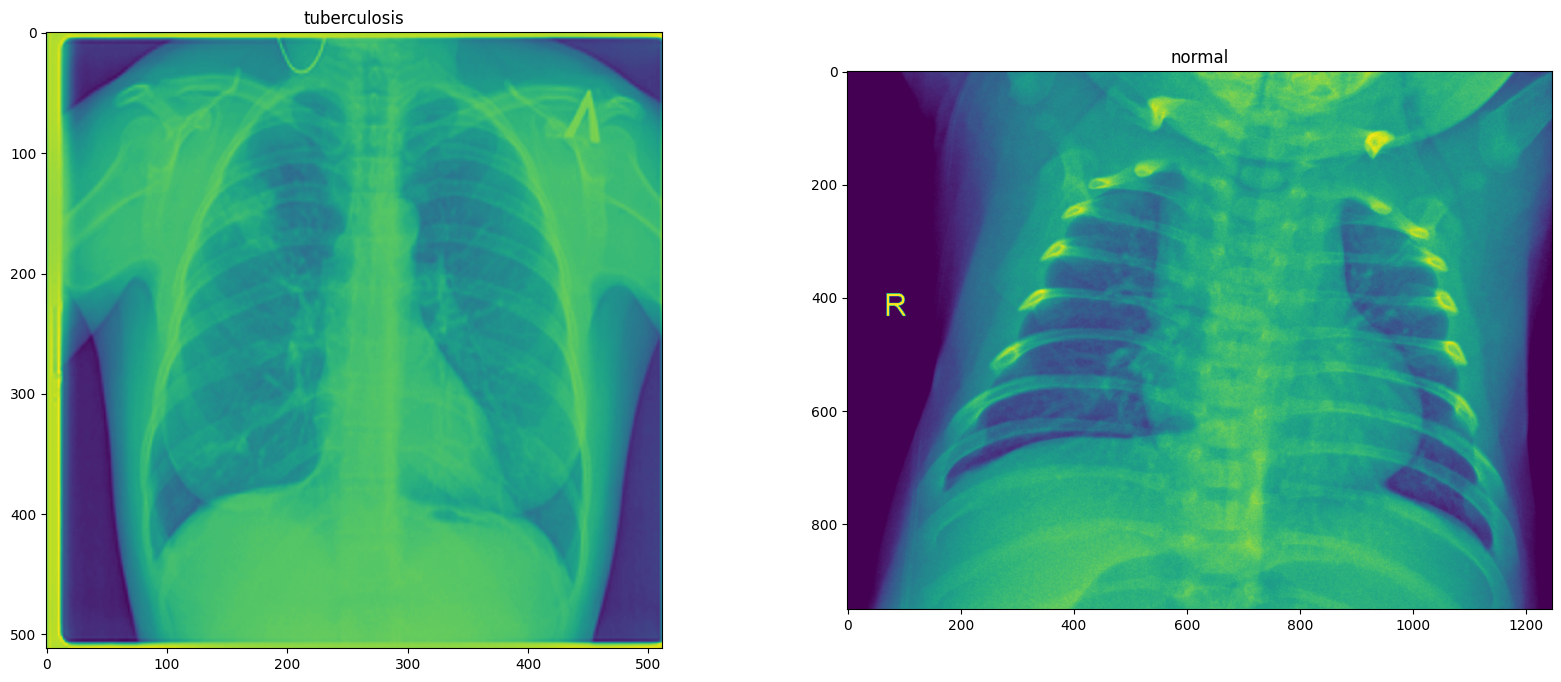

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
for i in range(len(target_var)):
    d = data_dir+target_var[i]+'/'+os.listdir(data_dir+target_var[i]+'/')[0]
    axes[i].imshow( plt.imread(d) )
    axes[i].set_title(target_var[i])
plt.show()

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 2041 files belonging to 2 classes.


In [ ]:
batch_size = 32
len(data)

64

# Data Split

In [ ]:
train_size = int(len(data)* .7)
valid_size = int(len(data)* .2) + 1
test_size = int(len(data)* .1) + 1
train_size + valid_size + test_size

64

In [ ]:
train = data.take(train_size)
valid = data.skip(train_size).take(valid_size)
test = data.skip(train_size).skip(valid_size).take(test_size)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

# Optimizer

In [ ]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, params, grads):
        if not self.m:
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.t += 1
        lr_t = self.learning_rate * (np.sqrt(1 - self.beta2 ** self.t) / (1 - self.beta1 ** self.t))

        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            v_hat = self.v[key] / (1 - self.beta2 ** self.t)
            params[key] -= lr_t * m_hat / (np.sqrt(v_hat) + self.epsilon)

In [ ]:
optimizer = AdamOptimizer()

# Model

In [ ]:
model = tf.keras.Sequential([
    layers.Input(shape=(256, 256, 3)),
])

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [ ]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(train,
    validation_data=valid,
    epochs=5)

Epoch 1/5
44/44 [==============================] - 493s 11s/step - loss: 52.8369 - accuracy: 0.7876 - val_loss: 0.1688 - val_accuracy: 0.9712
Epoch 2/5
44/44 [==============================] - 136s 3s/step - loss: 0.3994 - accuracy: 0.9517 - val_loss: 0.1463 - val_accuracy: 0.9712
Epoch 3/5
44/44 [==============================] - 133s 3s/step - loss: 0.1148 - accuracy: 0.9801 - val_loss: 0.0865 - val_accuracy: 0.9952
Epoch 4/5
44/44 [==============================] - 142s 3s/step - loss: 0.0757 - accuracy: 0.9893 - val_loss: 0.0716 - val_accuracy: 0.9856
Epoch 5/5
44/44 [==============================] - 134s 3s/step - loss: 0.0328 - accuracy: 0.9922 - val_loss: 0.0470 - val_accuracy: 0.9928


# Model Stats

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'],color='orange', label='val-loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  x,y = batch
  yhat = tuberculosis_model.predict(x)
  precision.update_state(y, yhat)
  recall.update_state(y, yhat)
  accuracy.update_state(y, yhat)

In [ ]:
print(f'Accuracy: {accuracy.result().numpy()}, Precision:{precision.result().numpy()}, Recall: {recall.result().numpy()}')

# Testing Data

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [ ]:
img_path = '/content/drive/MyDrive/tuberculosis_dataset/covid/04.png'
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
plt.imshow(img)
plt.show()

In [ ]:
img_array = np.expand_dims(img_array, axis=0)

In [ ]:
img_array = image.img_to_array(img)

In [ ]:
img_array = preprocess_input(img_array)

In [ ]:
predictions = tuberculosis_model.predict(img_array)
predictions

In [ ]:
if predictions > 0.5:
  print("Predicted as tuberculosis")
else:
  print("Predicted as normal")

# Save the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
tuberculosis_model.save('drive/MyDrive/trainedModels/tuberculosisModel.h5')

In [ ]:
tuberculosis_model.save('drive/MyDrive/trainedModels/tuberculosisModel.keras')

In [ ]:
new_model = load_model('drive/MyDrive/trainedModels/tuberculosisModel.h5')

In [ ]:
new_model.predict(img_array)